<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/fitting_temporal_filter_models_to_behavior_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis and prediction using a machine learning approach
__Content creator:__ David Fox

In [4]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models

Cloning into 'neuro_encoding_models'...
remote: Enumerating objects: 598, done.
remote: Total 598 (delta 0), reused 0 (delta 0), pack-reused 598
Receiving objects: 100% (598/598), 80.63 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (346/346), done.


In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# check the location of our data file

In [22]:
% ls -la /content/drive/MyDrive/temporal_filter_data_files_for_colab/

total 68523
-rw------- 1 root root 70166534 Nov 17 17:22 control_stim_to_behavior.mat


In [5]:
%cd neuro_encoding_models/

/content/neuro_encoding_models


In [7]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [54]:
#@title import modules
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
from glmtools.make_xdsgn import Experiment, DesignSpec
from basisFactory.bases import Basis, RaisedCosine
from scipy.optimize import minimize
from glmtools.fit import x_proj, fit_nlin_hist1d, normalize
from utils import plot as nmaplt
import pickle
from numpy import linalg as LA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from utils.read import load_behavior2
from joblib import Parallel, delayed

In [8]:
#@title helper functions
def make_bases(dur, peaks, stim_nbases, stretch, dt=0.02):
	fs = 1. / dt
	first_peak, last_peak = peaks
	
	nkt = int(dur * fs) # length of filter in number of samples
	# stim_nbases = number of vectors that are raised cosines
	stim_basis = RaisedCosine(100, stim_nbases, 1, 'stim')
 
	# arguments for makeNonlinearRaisedCosStim are 
	# dt sample interval
	# peaks = [position of first center, position of last center], 
	# stretch = spacing of basis centers (higher value = more linear meaning spread out,
	# lower value = nonlinear more centers near 0)
	# nkt = length of filter. If length of filters exceeds nkt we trim the filters, 
	# otherwise we pad with 0's
	# stim_basis.makeNonlinearRaisedCosStim(.1, [10, round(nkt/1.7)], stretch, nkt)  # first and last peak positions,
	stim_basis.makeNonlinearRaisedCosStim(.1, [first_peak / dt, last_peak / dt], stretch, nkt)
	return stim_basis


def make_dspec(stim, response, dt):
	# make an Experiment object
	expt = Experiment(dt, len(stim)*dt, stim=stim, response=response)

	# register continuous regressor
	expt.registerContinuous('stim')

	# initialize design spec with one trial
	return DesignSpec(expt, [0])
 



 

In [7]:
#@title graph properties
plt.rc('lines', linewidth=2, color='red')
font = {'family' : 'arial',
        'size'   : 20}
plt.rc('font', **font)

Objectives: We will use ridge regression  to forecast the response of flies during dynamic odor presentations. Ridge regularization is used to find a temporal filter that generalizes to all parts of the response and thus avoids overfitting. We use the model to predict the behavior and to evaluate the performances of the model on held-out data.

# 1. Load the data and plot the stimulus and response


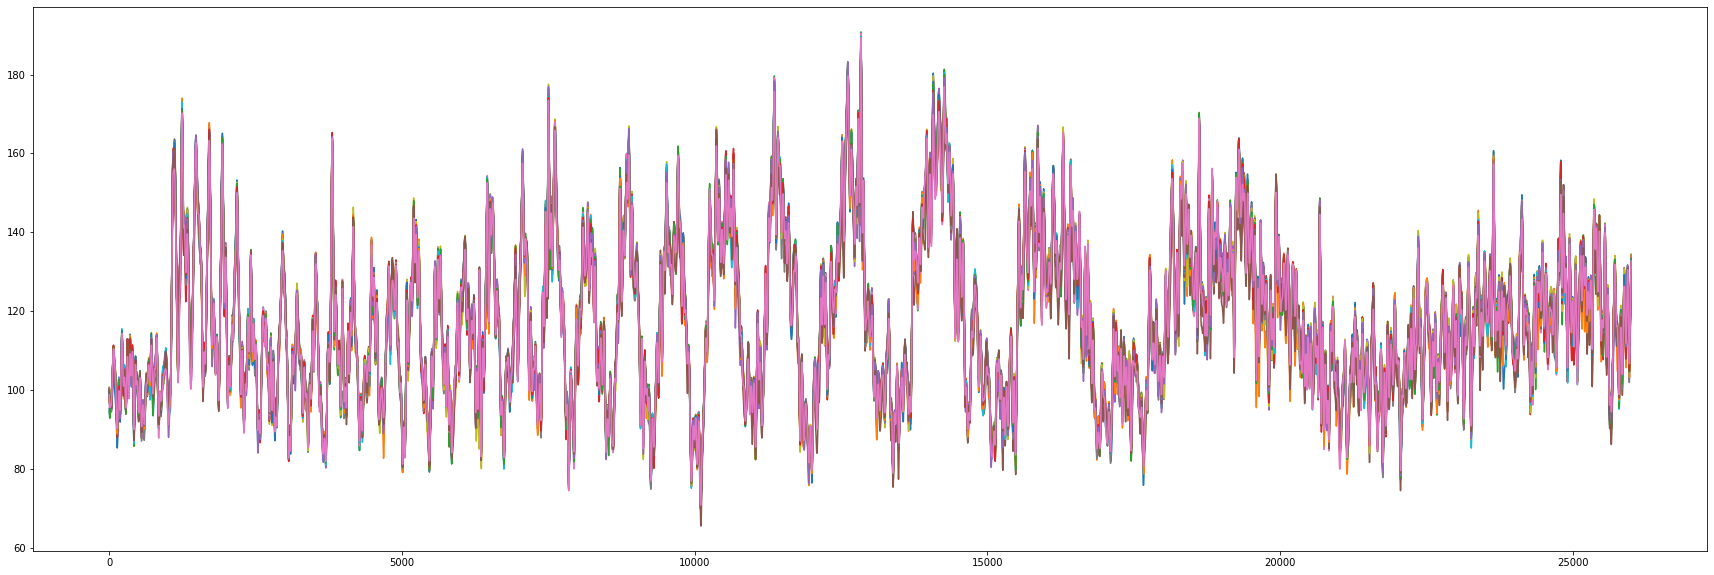

In [115]:
behavior_par = "vmoves"
behavior_par = "angvturns"
#behavior_par = "vymoves"
# load behavior from MATLAB .mat file
stim, response, dt = load_behavior2('datasets/stim.txt', '/content/drive/MyDrive/temporal_filter_data_files_for_colab/control_stim_to_behavior.mat', behavior_par)

plt.figure(figsize=[30, 10]);
plt.plot(response);
# response_ = response.mean(axis=1)
# stim = stim[:, 0]

# fs = 1000
# t = np.arange(len(stim)) / fs
# stim = stim.reshape((len(stim), 1))
# response = response.reshape((len(stim), 1))
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=[20, 5])
# ax[0].plot(t, stim)
# ax[1].plot(t, response)
# ax[1].set_xlabel('Time (s)')
# ax[1].set_ylabel('Ground Speed \n(mm/s)')
# ax[1].set_title('Olfactory Stimulus')
# ax[1].set_title('Ground Speed response')
# plt.tight_layout()

# Transform our stimulus (input) to a new basis of raised cosines

The ultimate output of the regression is a set of filter weights that define a stimulus temporal filter. We already have an idea about how such temporal filters should look. Briefly, events that happened closer in time to the response should be weighted highly than events further back in time. Temporal filters often have structure at both short- and long time scales and we can use a express our stimulus in terms of weights in a simple basis.

Here we build low-dimensional space spanned by raised cosines. This is called our filter bank and we will use this to transform our stimulus.  

# Make a collection of basis vectors
Specify the following argments to the `make_bases` function:

1.   duration of filter 
2.   position of filter centers [first peak time, last peak time]
3.   center stretch parameter
4.   Number of basis vectors

See example below



Text(0.5, 1.0, 'Raised Cosine basis')

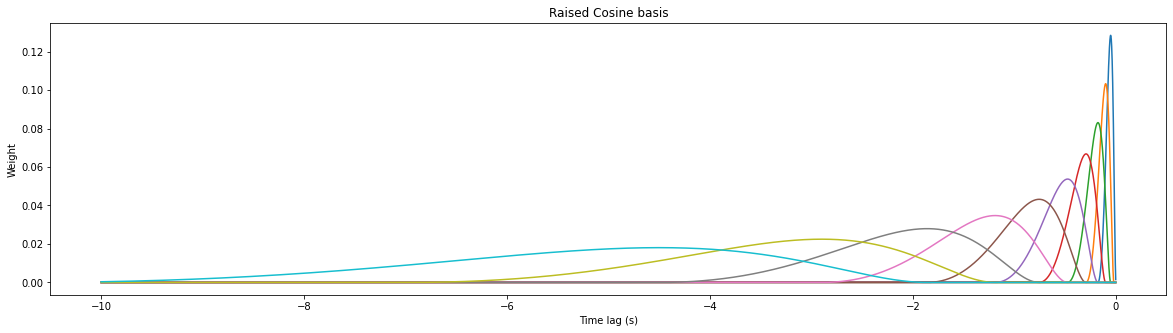

In [116]:
stim_basis = make_bases(10, [0.05, 4.5], 10, 40, dt=0.001) 
t = np.arange(-len(stim_basis.B), 0) * dt

fig, ax = plt.subplots(1, 1, figsize=[20, 5])
ax.plot(t, stim_basis.B);
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Weight')
ax.set_title('Raised Cosine basis')

# Split resampled traces into folds for train and test so we can do 5-fold cross-validation to find the best ridge penalty

at some point it would be worth putting the preprocessing steps into an sklearn pipeline

In [117]:
ntrials = response.shape[1]
inds = np.arange(ntrials)  # trial indices used to make splits

folds_xtrain = []
folds_xtest = []
folds_ytrain = []
folds_ytest = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(inds)

for train_index, test_index in kf.split(inds):
  # each fold will consist of a design matrix that will have concatenated trials for that fold
  # e.g. the first fold will train on trials 1, 2, 3 and test on 0
  # the second fold will train on 0, 2, 3 and test on 1
  print("TRAIN:", train_index, "TEST:", test_index)

  # use the inds to take a slice of sps and make a train design matrix
  train_dspec = make_dspec(stim[:, train_index], response[:, train_index], dt)
  train_dspec.addRegressorContinuous(basis=stim_basis)

  # use the inds to take a slice of sps and make a test design matrix
  test_dspec = make_dspec(stim[:, test_index], response[:, test_index], dt)
  test_dspec.addRegressorContinuous(basis=stim_basis)

  dm, X_train, y_train = train_dspec.compileDesignMatrixFromTrialIndices(bias=1);
  dm, X_test, y_test = test_dspec.compileDesignMatrixFromTrialIndices(bias=1);

  folds_xtrain.append(X_train)
  folds_xtest.append(X_test)
  folds_ytrain.append(y_train)
  folds_ytest.append(y_test)
;

  0%|          | 0/1 [00:00<?, ?it/s]

TRAIN: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36] TEST: [0 1 2 3 4 5 6 7]


  0%|          | 0/1 [00:00<?, ?it/s]

TRAIN: [ 0  1  2  3  4  5  6  7 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36] TEST: [ 8  9 10 11 12 13 14 15]


  0%|          | 0/1 [00:00<?, ?it/s]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 23 24 25 26 27 28 29 30
 31 32 33 34 35 36] TEST: [16 17 18 19 20 21 22]


  0%|          | 0/1 [00:00<?, ?it/s]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 30
 31 32 33 34 35 36] TEST: [23 24 25 26 27 28 29]


  0%|          | 0/1 [00:00<?, ?it/s]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] TEST: [30 31 32 33 34 35 36]


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


''

# create the design matrices for train and test


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: set_ticks() must have been called.


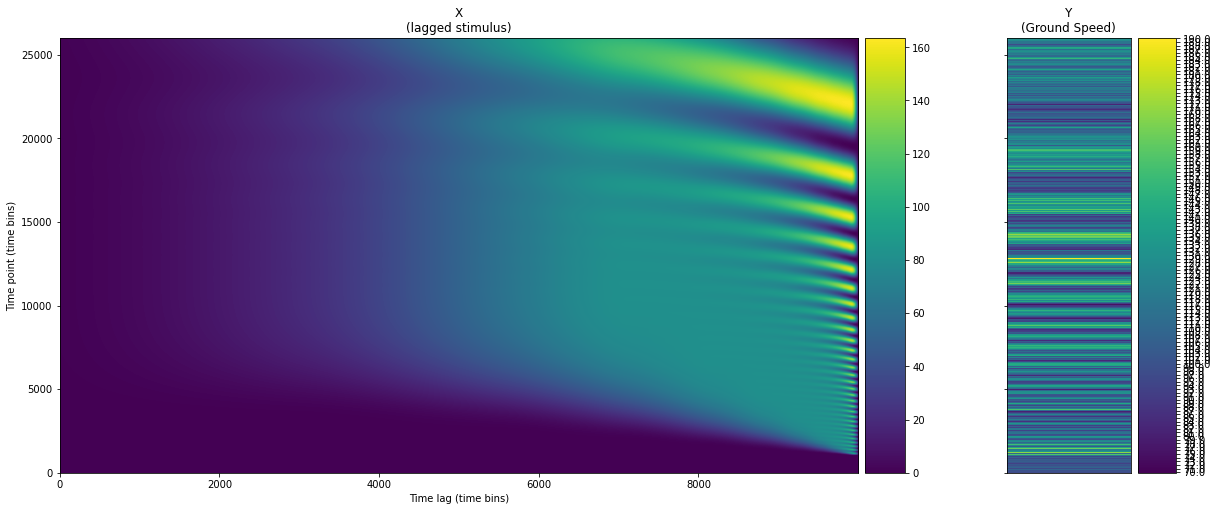

In [118]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is our design matrix
f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(20, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )


imx = ax_x.imshow(X_train[:, 1:] @ stim_basis.B.T,
            interpolation='nearest', aspect='auto')
imy = ax_y.pcolormesh(y_train.reshape(-1, 1))
ax_y.invert_yaxis()

ax_y.set(
    title="Y\n(Ground Speed)",
    xticks=[]
  )

plt.setp(ax_y.spines.values(), visible=True)


ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    # xticks=[0, 100, 200, 300, 400, 500],
    # xticklabels=['-12', '-10', '-8', '-6', '-4', '-2'],
    ylabel="Time point (time bins)",
  )
plt.setp(ax_x.spines.values(), visible=True)

divy = make_axes_locatable(ax_y)
caxy = divy.append_axes("right", size="30%", pad=0.1)
cbary = f.colorbar(imy, cax=caxy)
cbary.set_ticks(np.arange(y_train.max()) + .5)
cbary.set_ticklabels(np.arange(y_train.max()))

divx = make_axes_locatable(ax_x)
caxx = divx.append_axes("right", size="5%", pad=0.1)
cbarx = f.colorbar(imx, cax=caxx)
cbarx.set_ticklabels(np.sort(np.unique(X_train)))

# Now perform cross-validation to find the ridge penalty that gives the best average mse across validation folds
An explanation of Ordinary Least Squares can be found here:

https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf

Ridge regression is an extension of Ordinary Least Squares and is used to prevent overfitting to specific data:

https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db

To find the ridge penalty, we use a time series version of K-fold cross-validation.

In [119]:
def ridgefitCV(train, test, parameter):
	
  msetest_fold = 0
  for train, test in zip(train, test):
    Xtrain, ytrain = train
    Xtest, ytest = test

    model = Ridge(alpha=parameter).fit(Xtrain, ytrain)

    msetest_fold += mean_squared_error(ytest, model.predict(Xtest))

  # take the average mse across folds for this alpha
  return msetest_fold / len(train)


In [120]:
lamvals = np.logspace(0, 20, num=20, base=2)

def _run_search(evaluate_candidates):
  """Search all candidates in param_grid"""
  evaluate_candidates(lamvals)


parallel = Parallel(n_jobs=10, verbose=10)

all_out = []


with parallel:

  def evaluate_candidates(candidate_params):
    out = parallel(delayed(ridgefitCV)(train=zip(folds_xtrain, folds_ytrain), 
                                          test=zip(folds_xtest, folds_ytest),
                                          parameter=param)
                  for param in candidate_params) 

    all_out.extend(out)

_run_search(evaluate_candidates)

print(all_out)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  20 | elapsed:    1.0s remaining:    4.0s
[Parallel(n_jobs=10)]: Done   7 out of  20 | elapsed:    1.3s remaining:    2.4s
[Parallel(n_jobs=10)]: Done  10 out of  20 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=10)]: Done  13 out of  20 | elapsed:    1.9s remaining:    1.0s
[Parallel(n_jobs=10)]: Done  16 out of  20 | elapsed:    2.0s remaining:    0.5s


[421.82134150480283, 421.8213415102296, 421.8213415214863, 421.82134154483623, 421.8213415932715, 421.82134169374183, 421.8213419021513, 421.8213423344694, 421.8213432312842, 421.8213450917836, 421.82134895201534, 421.8213569635438, 421.8213736000455, 421.8214081871188, 421.82148026532855, 421.8216312065537, 421.8219503823017, 421.82263798974253, 421.8241690764565, 421.8277556777615]


[Parallel(n_jobs=10)]: Done  20 out of  20 | elapsed:    3.0s finished


best ridge param is 1.0


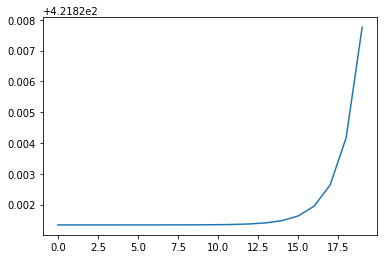

In [121]:
imin = np.argmin(all_out)
print("best ridge param is {}".format(lamvals[imin]))
plt.plot(all_out)


In [122]:
lamvals[imin]

# run ridge with the best alpha on the average response

dspec = make_dspec(stim[:, 0], response.mean(axis=1), dt)
dspec.addRegressorContinuous(basis=stim_basis)
dm, X, y = train_dspec.compileDesignMatrixFromTrialIndices(bias=1);

model = Ridge(alpha=lamvals[imin]).fit(X, y)

w = model.coef_


100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


In [123]:
w
d = dm.get_regressor_from_output(w)

# # convert back to the original basis to get nkt filter weights.
# # Parameters are returned in a dict
dc = w[0]
k = d['stim'][1]
kt = d['stim'][0] * dt

xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim[:, 0], response.mean(axis=1), k, dt, 20)
basis_score = r2_score(response.mean(axis=1), fnlin(rawfilteroutput))
basis_mse = mean_squared_error(response.mean(axis=1), fnlin(rawfilteroutput))

# Ridge regression and CV

Text(0.5, 1.0, 'Stimulus temporal filter for ground speed')

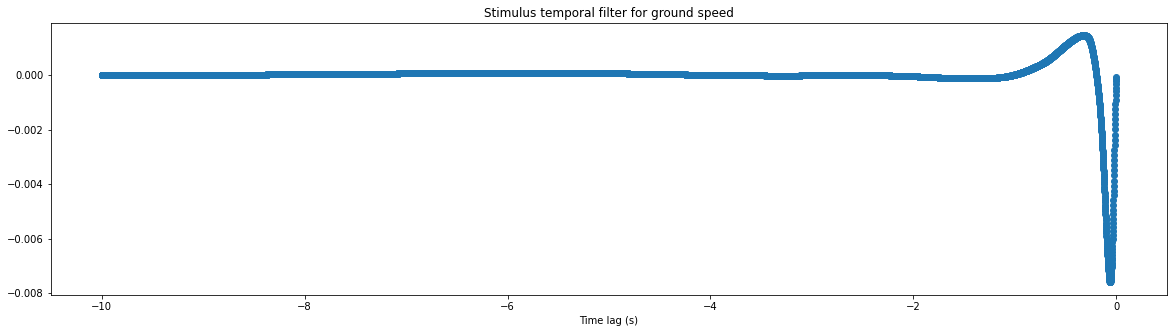

In [124]:
# convert back to the original basis to get nkt filter weights.
# Parameters are returned in a dict
dc = w[0]
k = d['stim'][1]
kt = d['stim'][0] * 0.001

plt.figure(figsize=[20, 5])
plt.plot(kt, k, 'o-')
plt.xlabel('Time lag (s)')
plt.title('Stimulus temporal filter for ground speed')

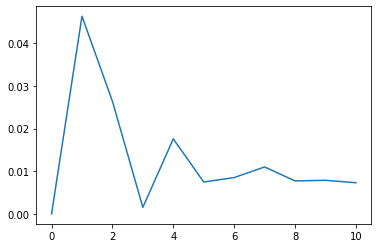

In [125]:
plt.plot(abs(w))

# Lets see how well this model describes the data

In [126]:
fs = 1000
stim_ = stim[:, 0]
response_ = response.mean(axis=1)

xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim_, response_, k, dt, 40)


The r2 on the held-out test set is 0.6034370883870823
The mse on the held-out test set is 143.72213701546391


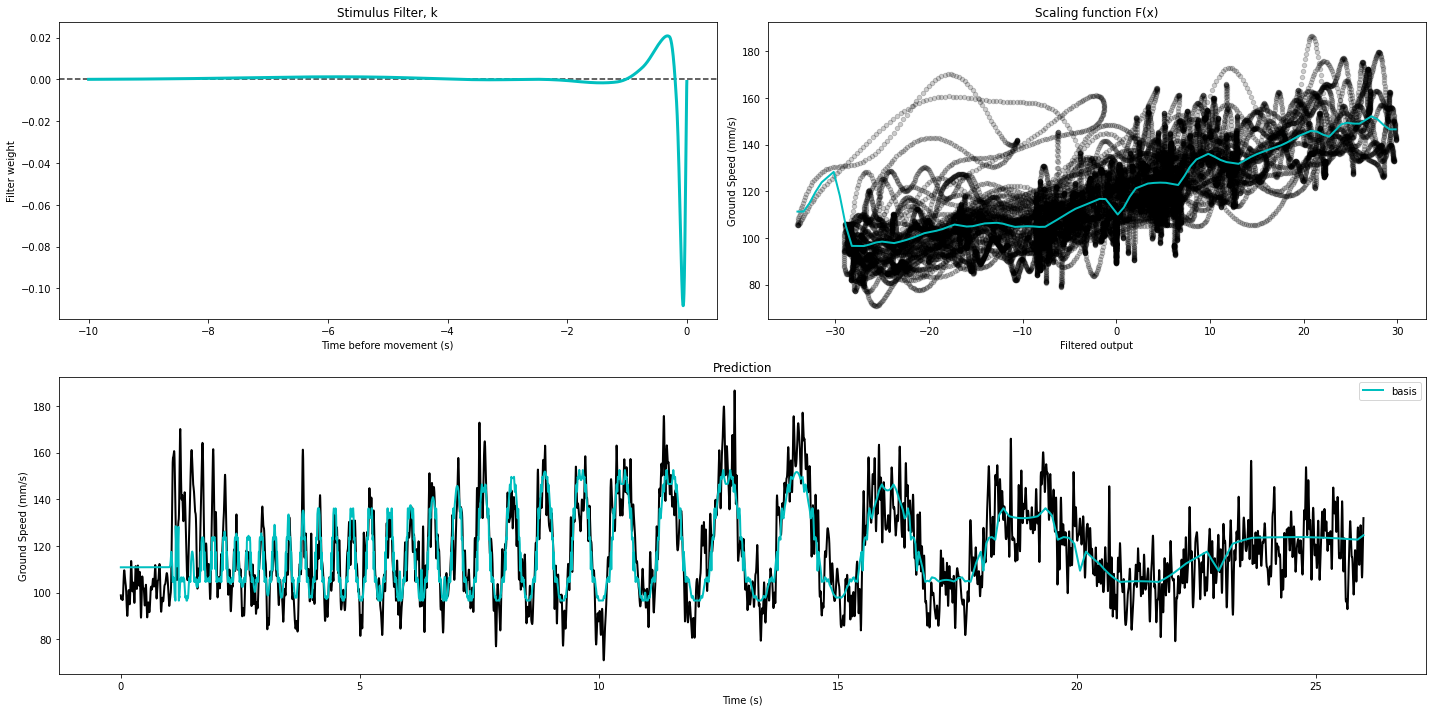

In [127]:
fig = plt.figure(figsize=[20, 10])
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

nmaplt.plot_spike_filter(ax1, k/LA.norm(k), dt, linewidth=3, color='c', label="basis")
# ax1.set_xlim(-5, 0)
ax1.set_xlabel('Time before movement (s)')
ax2.scatter(rawfilteroutput, response_, s=20, c='k', alpha=0.2)
ax2.plot(xx, fnlin(xx), 'c', linewidth=2)

t = np.arange(0, len(stim_)) / fs
ax3.plot(t, response_, 'k', linewidth=2)
ax3.plot(t, fnlin(rawfilteroutput), 'c', linewidth=2, label="basis")

ax3.set_ylabel('Ground Speed (mm/s)')
ax3.set_xlabel('Time (s)')
ax2.set_xlabel('Filtered output')
ax2.set_ylabel('Ground Speed (mm/s)')
ax2.set_title('Scaling function F(x)')

ax1.set_title('Stimulus Filter, k')

ax3.set_title("Prediction")
ax3.legend()

ridge_score = r2_score(response_, fnlin(rawfilteroutput))
basis_mse = mean_squared_error(response_, fnlin(rawfilteroutput))

print('The r2 on the held-out test set is {}'.format(basis_score))
print('The mse on the held-out test set is {}'.format(basis_mse))

plt.tight_layout()
plt.show()